In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
import os

os.environ["WANDB_DISABLED"] = "true"

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

# BERT_PATH = "../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased"

data_dir = Path('./input/AI4Code')

In [2]:
NUM_TRAIN = 200


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 294.40it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
003f36ab2c577d 386d31f0      code  import numpy as np\nimport pandas as pd\nimport tensorflow as tf\n# import tf2_0_baseline_w_bert as tf2baseline # ol...
               16435878      code  def del_all_flags(FLAGS):\n    flags_dict = FLAGS._flags()\n    keys_list = [keys for keys in flags_dict]\n    for k...
               f4bb282f      code  bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)\n\ntf2baseline.validate_flags_or_throw(bert...
               4cc5ee5a      code                                                       test_answers_df = pd.read_json("/kaggle/working/predictions.json")
               215ec8c0      code  def create_short_answer(entry):\n    # if entry["short_answers_score"] < 1.5:\n    #     return ""\n    \n    answer...
...                           ...                                                                                                                      ...
fdd4fc31053b84 2b0bb2b1      code                                                                                                         learn.unfreeze()
               d8c256ac      code                                                                                                   learn.fit_one_cycle(3)
               633e3393      code                                                                                                          learn.lr_find()
               9ef4c5c0      code                                                                                                    learn.recorder.plot()
               6e0e2dc8  markdown                                                    #Inspired by fast.ai Practical Deep Learning for Coders(v3) lession 1

[9176 rows x 2 columns]

In [3]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

/tmp/ipykernel_74449/499128900.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df_orders = pd.read_csv(


id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [4]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

In [5]:
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
003f36ab2c577d 386d31f0    2
               16435878    4
               f4bb282f    6
               4cc5ee5a    8
               215ec8c0   10
...                      ...
fdd4fc31053b84 2b0bb2b1   18
               d8c256ac   19
               633e3393   20
               9ef4c5c0   21
               6e0e2dc8    0

[9176 rows x 1 columns]

In [6]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


In [7]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,003f36ab2c577d,386d31f0,code,import numpy as np\nimport pandas as pd\nimport tensorflow as tf\n# import tf2_0_baseline_w_bert as tf2baseline # ol...,2,8508be37,3bde8d65a3508b
1,003f36ab2c577d,16435878,code,def del_all_flags(FLAGS):\n flags_dict = FLAGS._flags()\n keys_list = [keys for keys in flags_dict]\n for k...,4,8508be37,3bde8d65a3508b
2,003f36ab2c577d,f4bb282f,code,bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)\n\ntf2baseline.validate_flags_or_throw(bert...,6,8508be37,3bde8d65a3508b
3,003f36ab2c577d,4cc5ee5a,code,"test_answers_df = pd.read_json(""/kaggle/working/predictions.json"")",8,8508be37,3bde8d65a3508b
4,003f36ab2c577d,215ec8c0,code,"def create_short_answer(entry):\n # if entry[""short_answers_score""] < 1.5:\n # return """"\n \n answer...",10,8508be37,3bde8d65a3508b
...,...,...,...,...,...,...,...
9171,fdd4fc31053b84,2b0bb2b1,code,learn.unfreeze(),18,30c6c43b,NaN
9172,fdd4fc31053b84,d8c256ac,code,learn.fit_one_cycle(3),19,30c6c43b,NaN
9173,fdd4fc31053b84,633e3393,code,learn.lr_find(),20,30c6c43b,NaN
9174,fdd4fc31053b84,9ef4c5c0,code,learn.recorder.plot(),21,30c6c43b,NaN


<AxesSubplot:>

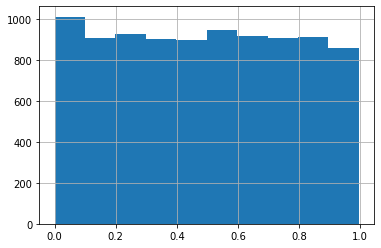

In [8]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

In [9]:
# pre process 전!
dict_cellid_source = dict(zip(df['cell_id'].values, df['source'].values))

In [18]:
dict_cellid_source

{'386d31f0': 'import numpy as np\nimport pandas as pd\nimport tensorflow as tf\n# import tf2_0_baseline_w_bert as tf2baseline # old script\nimport tf2_0_baseline_w_bert_translated_to_tf2_0 as tf2baseline # my script\nimport bert_modeling as modeling\nimport bert_optimization as optimization\nimport bert_tokenization as tokenization\nimport json\nimport absl\nimport sys\n\n# Input data files are available in the "../input/" directory.\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n# In this case, we\'ve got some extra BERT model files under `/kaggle/input/bertjointbaseline`\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))',
 '16435878': 'def del_all_flags(FLAGS):\n    flags_dict = FLAGS._flags()\n    keys_list = [keys for keys in flags_dict]\n    for keys in keys_list:\n        FLAGS.__delattr__(keys)\n\ndel_all_flag

In [20]:
import numpy as np
import pandas as pd
import os
import re
# import fasttext
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from pathlib import Path
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    
def preprocess_df(df):
    """
    This function is for processing sorce of notebook
    returns preprocessed dataframe
    """
    return [preprocess_text(message) for message in df.source]

df.source = df.source.apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/innoacad05/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/innoacad05/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,003f36ab2c577d,386d31f0,code,import numpy import panda import tensorflow import tf2_0_baseline_w_bert tf2baseline script import tf2_0_baseline_w_...,2,8508be37,3bde8d65a3508b,0.095238
1,003f36ab2c577d,16435878,code,del_all_flags flag flags_dict flag _flags keys_list flags_dict keys_list flag __delattr__ del_all_flags absl flag fl...,4,8508be37,3bde8d65a3508b,0.190476
2,003f36ab2c577d,f4bb282f,code,bert_config modeling bertconfig from_json_file flag bert_config_file tf2baseline validate_flags_or_throw bert_config...,6,8508be37,3bde8d65a3508b,0.285714
3,003f36ab2c577d,4cc5ee5a,code,test_answers_df read_json kaggle working prediction json,8,8508be37,3bde8d65a3508b,0.380952
4,003f36ab2c577d,215ec8c0,code,create_short_answer entry entry short_answers_score return answer short_answer entry short_answers short_answer star...,10,8508be37,3bde8d65a3508b,0.47619


In [11]:
from tqdm import tqdm
import sys, os
try:
    from transformers import DistilBertModel, DistilBertTokenizer
except:
  !pip install transformers
  from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

In [52]:
def generate_triplet(df, mode='train'):
    triplets = []
    ids = df.id.unique() #notebook id
    random_drop = np.random.random(size=10000)>0.9
    count = 0

    #df의 모든 노트북 반복
    for id, df_tmp in tqdm(df.groupby('id')): #같은 노트북
        df_tmp_markdown = df_tmp[df_tmp['cell_type']=='markdown'] #마크다운만

        df_tmp_code = df_tmp[df_tmp['cell_type']=='code'] #코드셀
        df_tmp_code_rank = df_tmp_code['rank'].values #코드셀 rank(순서)
        df_tmp_code_cell_id = df_tmp_code['cell_id'].values #코드셀 셀id

        for cell_id, rank in df_tmp_markdown[['cell_id', 'rank']].values: #마크다운 셀id, 랭크만 가져와서
            labels = np.array([(r==(rank+1)) for r in df_tmp_code_rank]).astype('int') #다음 순서의 코드셀 저장

            for cid, label in zip(df_tmp_code_cell_id, labels): #코드셀 id랑, 라벨 가져와서
                count += 1
                if label==1:    #다음 코드셀인거 일단 짝짝쿵은 다 가져옴
                    triplets.append( [cell_id, cid, label] ) #마크다운셀id, 코드셀id, 라벨 저장
                  # triplets.append( [cid, cell_id, label] )
                elif mode == 'test': #테스트 모드면 전부 다 넣는듯
                    triplets.append( [cell_id, cid, label] )
                  # triplets.append( [cid, cell_id, label] )
                elif random_drop[count%10000]: #0~1만 중 걸리면(0.1확률) - 왜????? 아 1은 상관있는거 0은 상관없는걸로 학습??
                    triplets.append( [cell_id, cid, label] )
                  # triplets.append( [cid, cell_id, label] )

    return triplets

triplets = generate_triplet(df)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 743.32it/s]


In [74]:
# df 내 모든 마크다운셀에 대한 대응코드셀 triplet 과 랜덤(label==0) triplet 을 가져옴
generate_triplet(df)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 771.39it/s]


[['3e1430c4', '4cc5ee5a', 1],
 ['6f70d84e', '16435878', 0],
 ['6f70d84e', '4cc5ee5a', 0],
 ['6f70d84e', '215ec8c0', 0],
 ['6f70d84e', '1d664ca8', 1],
 ['da99f684', '386d31f0', 1],
 ['da99f684', '4cc5ee5a', 0],
 ['db8c69de', '215ec8c0', 1],
 ['5948bc1a', '386d31f0', 0],
 ['5948bc1a', 'a3f4e6bc', 1],
 ['00070116', '05bc949b', 1],
 ['82dfbe9a', '16435878', 1],
 ['6d31400d', '16435878', 0],
 ['6d31400d', 'f4bb282f', 1],
 ['6d31400d', '1d664ca8', 0],
 ['6d31400d', '5c545af1', 0],
 ['c47a4a8e', '5c545af1', 1],
 ['c47a4a8e', 'a3f4e6bc', 0],
 ['42435be9', '3f201013', 0],
 ['42435be9', 'eb645be7', 0],
 ['8f4c4034', '7b78796e', 0],
 ['8f4c4034', '5d3d89e1', 0],
 ['8f4c4034', '41f19673', 1],
 ['0fa88287', '4afe7f61', 1],
 ['0fa88287', 'c878e995', 0],
 ['ed9b90a1', 'd416ce6e', 0],
 ['ed9b90a1', 'b4c1e48e', 0],
 ['ed9b90a1', '41f19673', 0],
 ['ed9b90a1', 'c878e995', 1],
 ['63466cff', '19a6b2db', 0],
 ['63466cff', '6583d7cf', 1],
 ['8f191e71', '41f19673', 0],
 ['8f191e71', '8bf7dfb5', 1],
 ['8f191e7

In [77]:
## generate_triplet 함수 TEST

for id, df_tmp in tqdm(df.groupby('id')): #같은 노트북
#     print(id)
    display(df_tmp.head())
    df_tmp_code = df_tmp[df_tmp['cell_type']=='code'] #코드셀
#     print(df_tmp_code['rank'].values)
    df_tmp_code_rank = df_tmp_code['rank'].values #코드셀 rank(순서)
    print(df_tmp_code_rank)
    df_tmp_code_cell_id = df_tmp_code['cell_id'].values #코드셀 셀id
    
    
    df_tmp_markdown = df_tmp[df_tmp['cell_type']=='markdown'] #마크다운만
#     print(df_tmp_markdown[['cell_id', 'rank']].values)
    for cell_id, rank in df_tmp_markdown[['cell_id', 'rank']].values:
        labels = np.array([(r==(rank+1)) for r in df_tmp_code_rank]).astype('int')
        print(labels)
        print(cell_id)
        for cid, label in zip(df_tmp_code_cell_id, labels):
            print(cid,label)
            break
        break
    
    break

  0%|                                                                                           | 0/200 [00:00<?, ?it/s]

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,003f36ab2c577d,386d31f0,code,import numpy import panda import tensorflow import tf2_0_baseline_w_bert tf2baseline script import tf2_0_baseline_w_...,2,8508be37,3bde8d65a3508b,0.095238
1,003f36ab2c577d,16435878,code,del_all_flags flag flags_dict flag _flags keys_list flags_dict keys_list flag __delattr__ del_all_flags absl flag fl...,4,8508be37,3bde8d65a3508b,0.190476
2,003f36ab2c577d,f4bb282f,code,bert_config modeling bertconfig from_json_file flag bert_config_file tf2baseline validate_flags_or_throw bert_config...,6,8508be37,3bde8d65a3508b,0.285714
3,003f36ab2c577d,4cc5ee5a,code,test_answers_df read_json kaggle working prediction json,8,8508be37,3bde8d65a3508b,0.380952
4,003f36ab2c577d,215ec8c0,code,create_short_answer entry entry short_answers_score return answer short_answer entry short_answers short_answer star...,10,8508be37,3bde8d65a3508b,0.47619


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]

[2 4 6 8 10 11 12 14 16 18 20]
[0 0 0 1 0 0 0 0 0 0 0]
3e1430c4
386d31f0 0


In [13]:
#metric.py
from bisect import bisect

def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max


In [14]:
from tqdm import tqdm
import sys, os
try:
    from transformers import DistilBertModel, DistilBertTokenizer
except:
    !pip install transformers
    !pip install sentencepiece
    from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel


import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import AlbertTokenizer, AlbertModel


MAX_LEN = 128
    
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        # pretrained 된 distillbert 모델
        self.distill_bert = AutoModel.from_pretrained("./input/mymodelbertsmallpretrained/checkpoint-120000")
        self.top = nn.Linear(512, 1)

        self.dropout = nn.Dropout(0.2)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.dropout(x)
        x = self.top(x[:, 0, :])
        x = torch.sigmoid(x) 
        return x

In [15]:
from torch.utils.data import DataLoader, Dataset



class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len, mode='train'):
        super().__init__()
        self.df = df
        self.max_len = max_len
        # pretrained 된 bert-small 토크나이저
        self.tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small", do_lower_case=True)
        self.mode=mode

    def __getitem__(self, index):
        row = self.df[index]

        label = row[-1]

        txt = dict_cellid_source[row[0]] + '[SEP]' + dict_cellid_source[row[1]]

        inputs = self.tokenizer.encode_plus(
            txt,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([label])




    def __len__(self):
        return len(self.df)


train_ds = MarkdownDataset(triplets, max_len=MAX_LEN, mode='test') #input data 가 triplet label 이 학습 label이 됨

train_ds[1]

(tensor([  101,  1001,  1001,  1001,  1001,  2085,  1010,  2057,  2735,  1036,
         20932,  1012,  1046,  3385,  1036,  2046,  1037,  1036, 12339,  1012,
         20116,  2615,  1036,  5371,  1012,   102,  3231,  1035,  6998,  1035,
          1040,  2546,  1027, 22851,  1012,  3191,  1035,  1046,  3385,  1006,
          1000,  1013, 10556, 24679,  1013,  2551,  1013, 20932,  1012,  1046,
          3385,  1000,  1007,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [16]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 5e-5
    elif epoch < 5:
        lr = 5e-5
    else:
        lr = 5e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-8 ) #1e-08)
    return optimizer

BS = 128 + 128
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)

In [17]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()

def validate(model, val_loader, mode='train'):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            if mode=='test':
              labels.append(target.detach().cpu().numpy().ravel())
    if mode=='test':
        return np.concatenate(preds)
    else:
        return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, epochs, Type='markdown'):
    np.random.seed(0)
    
    optimizer = get_optimizer(model)

    mixed_precision = True
    try:  
        from apex import amp
    except:
        mixed_precision = False  # not installed

    # model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=1)
    

    criterion = torch.nn.L1Loss()
    criterion = torch.nn.BCELoss()
    
    for e in range(epochs):   
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            pred = model(inputs[0], inputs[1])

            loss = criterion(pred, target)

            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")

        
        output_model_file = f"./my_own_model_{e}.bin"
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), output_model_file)





    return model



In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
model = MarkdownModel()
model = model.to(device)


model = train(model, train_loader, epochs=1, Type='markdown')


Some weights of the model checkpoint at ./input/mymodelbertsmallpretrained/checkpoint-120000 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./input/mymodelbertsmallpretrained/checkpoint-120000 and are newly initi

  0%|                                                                                                  | 0/65 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the 

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 4.75 GiB total capacity; 3.00 GiB already allocated; 62.00 MiB free; 3.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF